In [1]:
%load_ext autoreload
%autoreload 2

In [50]:
import matplotlib.pyplot as plt
import numpy as np 

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from tqdm.auto import tqdm

from qvi.core.distribution import QuantizedNormal, QMCNormal
from qvi.core.experiments import Experiment,compute_traces_from_multiple_trainning
from qvi.core.vi import build_meanfield_advi

from qvi.models.data import make_boston, make_forestfires,make_lifeexpect, make_frisk
from qvi.models.blr import (blr_conditioned_log_prob_fn, build_mc_br_posterior, 
                            build_quantized_br_posterior, build_qmc_br_posterior, 
                            build_qmcoffline_br_posterior, build_rqmc_br_posterior)

from qvi.models.glr import compute_target_log_prob_frisk_fn

from qvi.misc.utils import apply_expdim
from qvi.misc.plot import plot_experiments,scatter_plot_voronoi, plot2d, TFColor

plot_experiments_params = {
'font.family' : 'Verdana',
'figure.figsize' : [13, 10],
'font.size' : 14,
'axes.labelsize' : 16,
'xtick.labelsize' : 14,
'ytick.labelsize' : 14,
'xtick.major.size' : 6,
'xtick.minor.size' : 3,
'xtick.major.width' : 1,
'xtick.minor.width' : 1,
'ytick.major.size' : 6,
'ytick.minor.size' : 3,
'ytick.major.width' : 1,
'ytick.minor.width' : 1,
'legend.frameon' : False}


DATA_PATH = '../data/'
EXPERIMENTS_PATH = '../data/experiments/'

##Disable eagerly run if your system allows it. The computation time is reduced by several order of magnitude. 
## If not possible=, uncomment the following line.
#tf.config.experimental_run_functions_eagerly(True)

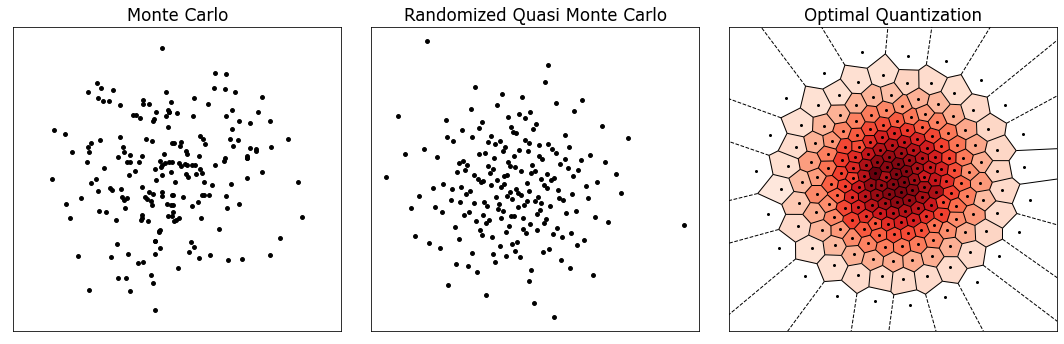

In [51]:
localisation = [0.,0.]
scale = [1.,1.]
n = 200

mc_samples = tfd.Normal(localisation, scale).sample(n).numpy()
qmc_samples = QMCNormal(localisation, scale).sample(n).numpy()
qdist = QuantizedNormal(localisation, scale)


with plt.rc_context(plot_experiments_params):
    fig, (mc_ax, qmc_ax, q_ax) = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
    plot2d(mc_samples, ax=mc_ax, c='black', s=15)
    plot2d(qmc_samples, ax=qmc_ax, c='black', s=15)
    scatter_plot_voronoi(qdist,n=n, ax=q_ax)
    
    for ax in (mc_ax, qmc_ax, q_ax):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        mc_ax.axis('equal')
        
    mc_ax.title.set_text('Monte Carlo')
    qmc_ax.title.set_text('Randomized Quasi Monte Carlo')
    q_ax.title.set_text('Optimal Quantization')
    
    plt.tight_layout()

# GLM

# Frisk

In [4]:
data = make_frisk(DATA_PATH + 'frisk.dat')
conditioned_log_prob, pooled_model = compute_target_log_prob_frisk_fn(data)
D = 32

build_mc_frisk_posterior = lambda D: build_meanfield_advi(pooled_model())
build_quantized_frisk_posterior = lambda D: build_meanfield_advi(pooled_model(), distribution=QuantizedNormal)
build_qmc_frisk_posterior = lambda D: build_meanfield_advi(pooled_model(), distribution=QMCNormal, randomized=False)
build_rqmc_frisk_posterior = lambda D: build_meanfield_advi(pooled_model(), distribution=QMCNormal, randomized=True)

In [ ]:
num_steps = 1000
sample_size = 10
optimizer = tf.optimizers.Adam

frisk_results = []
for lr in tqdm([3e-2, 5e-2, 7e-2]):
    exp  = Experiment(
    conditioned_log_prob=conditioned_log_prob,
    optimizer=optimizer,
    optimizer_params = {'learning_rate':lr},
    num_steps=num_steps,
    trace_fn=lambda loss,grads, variables: (loss, tf.timestamp(), tf.concat(apply_expdim(grads), axis=-1)),
    mc_surrogate_builder=build_mc_frisk_posterior,
    q_surrogate_builder=build_quantized_frisk_posterior,
    rq_surrogate_builder = None,
    qmc_surrogate_builder = build_qmc_frisk_posterior,
    rqmc_surrogate_builder = build_rqmc_frisk_posterior,
    D=D,
    M=10,
    sample_size=sample_size)
    # Number of Re-rerun for MC VI
    results = exp.run(20)
    frisk_results.append(exp)

In [ ]:
# abscissa 'time' or 'epochs'.

with plt.rc_context(plot_experiments_params):
    fig, axes = plt.subplots(2,len(frisk_results))
    plot_experiments(frisk_results, axes=axes, dataset=0,
                     dataset_name='Frisk', vi_type=[ 'mc', 'rqmc', 'qvi', 'qmc'],
                     limits = [0,None],
                     gradylimit=[(10e0,10e9), None]
                     , num_burnin_steps=20)
    plt.legend()
    for c in range(len(frisk_results)):
        axes[1,c].set_xlabel('time(s)')
    plt.tight_layout()
    axes[0,2].legend(['QMCVI','RQMCVI','QVI','MCVI'])
    axes[1,2].legend([])

# GLR

## Boston

In [ ]:
optimizer = tf.optimizers.Adam
num_steps = 1000

data, D = make_boston()
conditioned_log_prob = blr_conditioned_log_prob_fn(data)

sample_size = 20
boston_results = []
for lr in tqdm([1e-2, 4e-2, 8e-2]):
    exp  = Experiment(
    conditioned_log_prob=conditioned_log_prob,
    optimizer=optimizer,
    optimizer_params = {'learning_rate':lr},
    num_steps=num_steps,
    trace_fn= lambda loss,grads, variables: (loss, tf.timestamp(), tf.concat(grads,axis=0)),
    mc_surrogate_builder=build_mc_br_posterior,
    q_surrogate_builder=build_quantized_br_posterior,
    rq_surrogate_builder=build_quantized_br_posterior,
    qmc_surrogate_builder=build_qmc_br_posterior,
    rqmc_surrogate_builder=build_rqmc_br_posterior,
    D=D+1,
    M=10,
    sample_size=sample_size)
    
    results = exp.run(10)
    boston_results.append(exp)

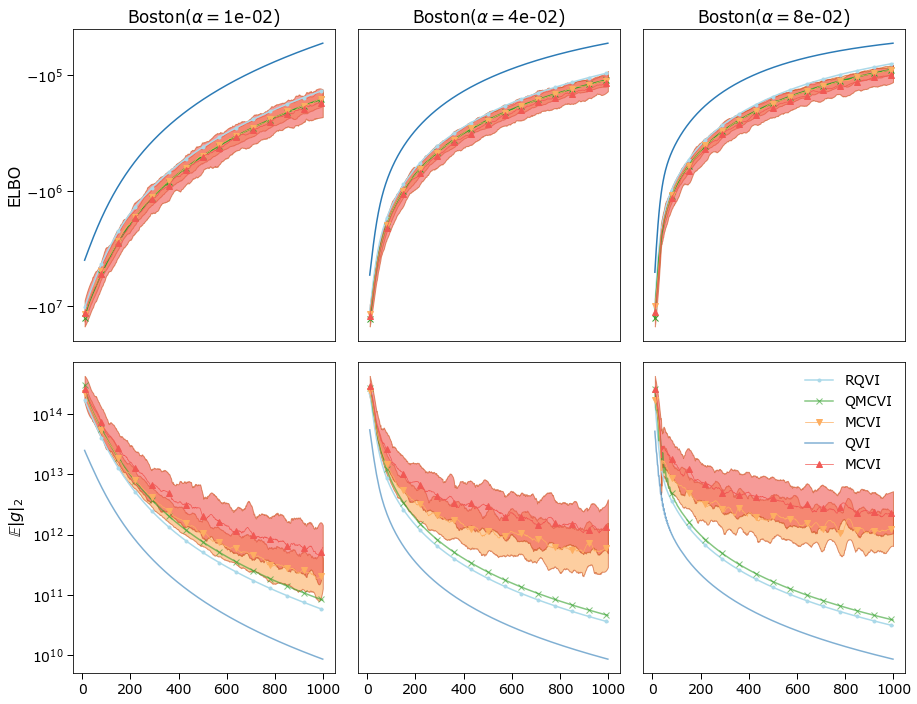

In [38]:
with plt.rc_context(plot_experiments_params):
    fig, axes = plt.subplots(2,len(boston_results))
    plot_experiments(boston_results, 
                     axes=axes, 
                     vi_type=['mc', 'qvi', 'rqmc', 'qmc', 'rqvi'],
                     dataset=0,
                     dataset_name='Boston',
                     num_burnin_steps=10)
    plt.legend()
    plt.tight_layout()

## Forest Fires

In [ ]:
optimizer = tf.optimizers.Adam
num_steps = 1000
sample_size = 20


data, D = make_forestfires(filepath=DATA_PATH + 'forestfires.csv')
conditioned_log_prob = blr_conditioned_log_prob_fn(data)

forestfires_results = []
for lr in tqdm([2e-2, 4e-2, 6e-2]):
    exp  = Experiment(
    conditioned_log_prob=conditioned_log_prob,
    optimizer=optimizer,
    optimizer_params = {'learning_rate':lr},
    num_steps=num_steps,
    trace_fn= lambda loss,grads, variables: (loss, tf.timestamp(), tf.concat(grads,axis=0)),
    mc_surrogate_builder=build_mc_br_posterior,
    q_surrogate_builder=build_quantized_br_posterior,
    rq_surrogate_builder=build_quantized_br_posterior,
    qmc_surrogate_builder=build_qmc_br_posterior,
    rqmc_surrogate_builder=build_rqmc_br_posterior,
    D=D+1,
    M=10,
    sample_size=sample_size)
    
    results = exp.run(20)
    forestfires_results.append(exp)

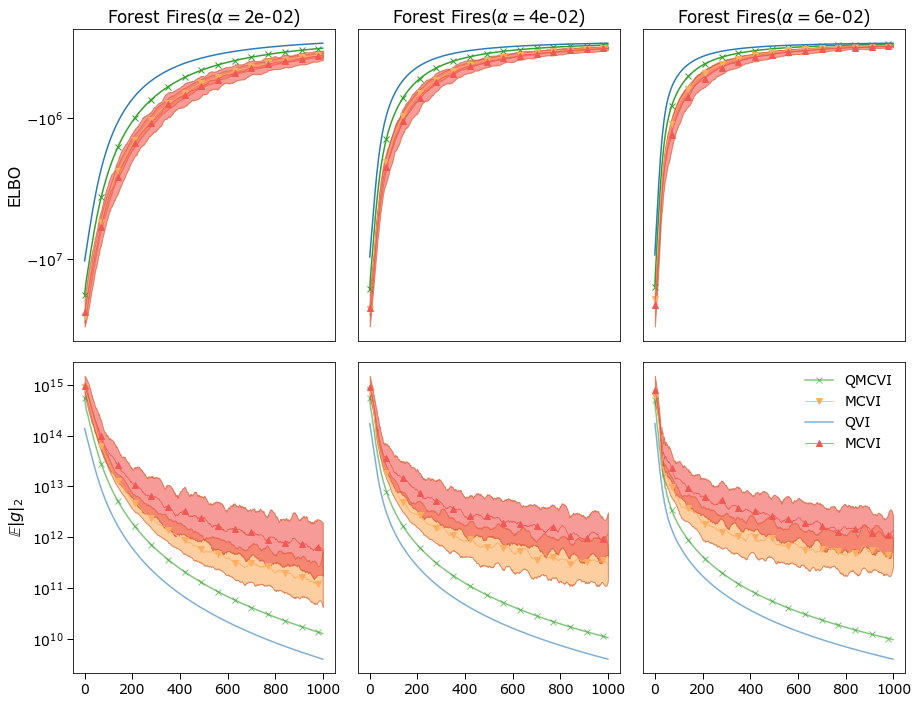

In [39]:
with plt.rc_context(plot_experiments_params):
    fig, axes = plt.subplots(2,len(forestfires_results))
    plot_experiments(forestfires_results, 
                     axes=axes, 
                     dataset=0,
                     dataset_name='Forest Fires' ,
                     vi_type=['mc', 'qvi', 'rqmc', 'qmc'])
    plt.legend()
    plt.tight_layout()

## Life Expectancy

In [ ]:
optimizer = tf.optimizers.Adam
num_steps = 1000
sample_size = 20

data, D = make_lifeexpect(filepath=DATA_PATH + 'lifeexpect.csv')
conditioned_log_prob = blr_conditioned_log_prob_fn(data)

le_results = []
for lr in tqdm([5e-3, 7e-3, 9e-3]):
    exp  = Experiment(
    conditioned_log_prob=conditioned_log_prob,
    optimizer=optimizer,
    optimizer_params = {'learning_rate':lr},
    num_steps=num_steps,
    trace_fn= lambda loss,grads, variables: (loss, tf.timestamp(), tf.concat(grads,axis=0)),
    mc_surrogate_builder=build_mc_br_posterior,
    q_surrogate_builder=build_quantized_br_posterior,
    rq_surrogate_builder=build_quantized_br_posterior,
    qmc_surrogate_builder=build_qmc_br_posterior,
    rqmc_surrogate_builder=build_rqmc_br_posterior,
    D=D+1,
    M=10,
    sample_size=sample_size)
    
    results = exp.run(20)
    le_results.append(exp)

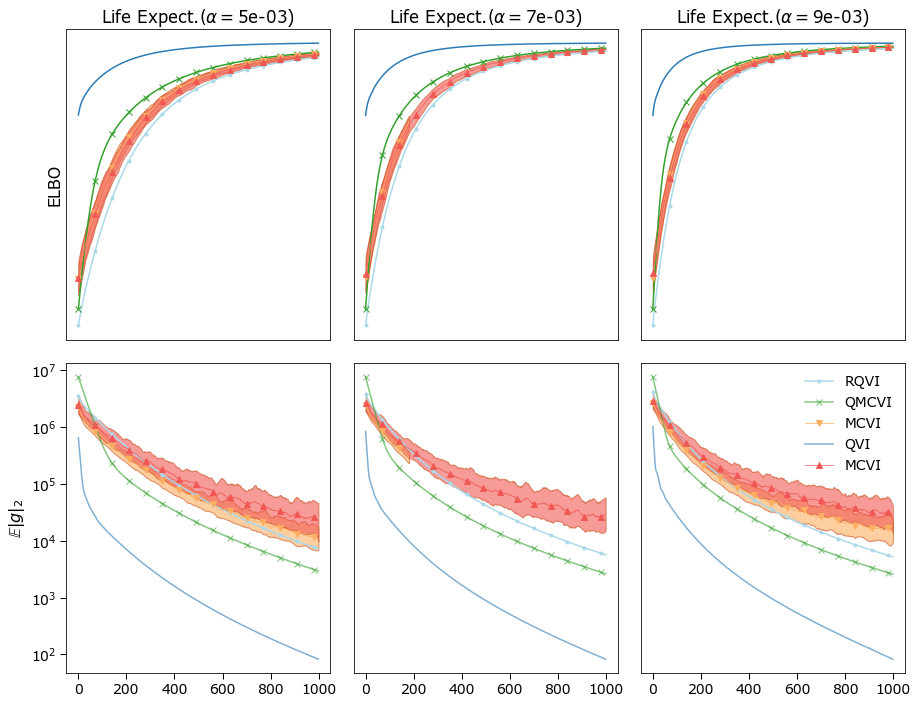

In [53]:
with plt.rc_context(plot_experiments_params):
    fig, axes = plt.subplots(2,len(le_results))
    plot_experiments(le_results, 
                     axes=axes, 
                     dataset=0,
                     dataset_name='Life Expect.', 
                     vi_type=[ 'mc','qvi', 'rqmc', 'qmc', 'rqvi'])
    plt.legend()
    plt.tight_layout()

# BNN

In [ ]:
from qvi.models.bnn import *
from qvi.misc.utils import split_to_nested_tensors

model,target, features, D, true_weights = train_bnn_keras(units=5)
bnn_weight_structure = list(map(lambda x: tf.TensorShape(x.shape),model.weights))

def compute_target_log_prob_bnn_fn():
    n_parameters = np.array(list(map(tf.reduce_prod,bnn_weight_structure))).sum()
    D = model.count_params()

    def pooled_model_simplified():
      """Creates a joint distribution representing our generative process."""
      return tfd.JointDistributionSequential([
        tfd.Independent(
            tfd.Normal(tf.zeros(n_parameters),.5),
            1),
        lambda weights:tfd.Independent(
          tfd.Normal(loc=load_predict_batch(model, weights, features), scale=.3),
            1)
      ])

    def conditioned_log_prob(weights, func_prob='log_prob'):
        return pooled_model().__getattribute__(func_prob)([weights, tf.reshape(target,[-1])])

    return conditioned_log_prob, D,pooled_model_simplified

@tf.function
def load_predict_batch(model, weights_sample, features):
    weights_sample = tf.expand_dims(weights_sample,axis=0) if tf.rank(weights_sample) == 1 else weights_sample
    splited_weights_samples = split_to_nested_tensors(weights_sample, bnn_weight_structure, axis=1)

    return tf.squeeze(neural_network_batch(features,*splited_weights_samples))

In [ ]:
bnn_conditioned_log_prob, D, pooled_model = compute_target_log_prob_bnn_fn()

num_steps = 2000
sample_size = 10
optimizer = tf.optimizers.Adam

bnn_results = []
for lr in tqdm([3e-3, 5e-3, 7e-3]):
    exp  = Experiment(
    conditioned_log_prob=bnn_conditioned_log_prob,
    optimizer=optimizer,
    optimizer_params = {'learning_rate':lr},
    num_steps=num_steps,
    trace_fn=trace_bnn,
    qmc_surrogate_builder = build_qmc_br_posterior,
    mc_surrogate_builder=build_mc_br_posterior,
    rqmc_surrogate_builder=build_rqmc_br_posterior,
    q_surrogate_builder=build_quantized_br_posterior,
    rq_surrogate_builder=None,
    D=D,
    M=10,
    sample_size=sample_size)
    # Number of Re-rerun for MC VI
    res = exp.run(20)
    bnn_results.append(exp)

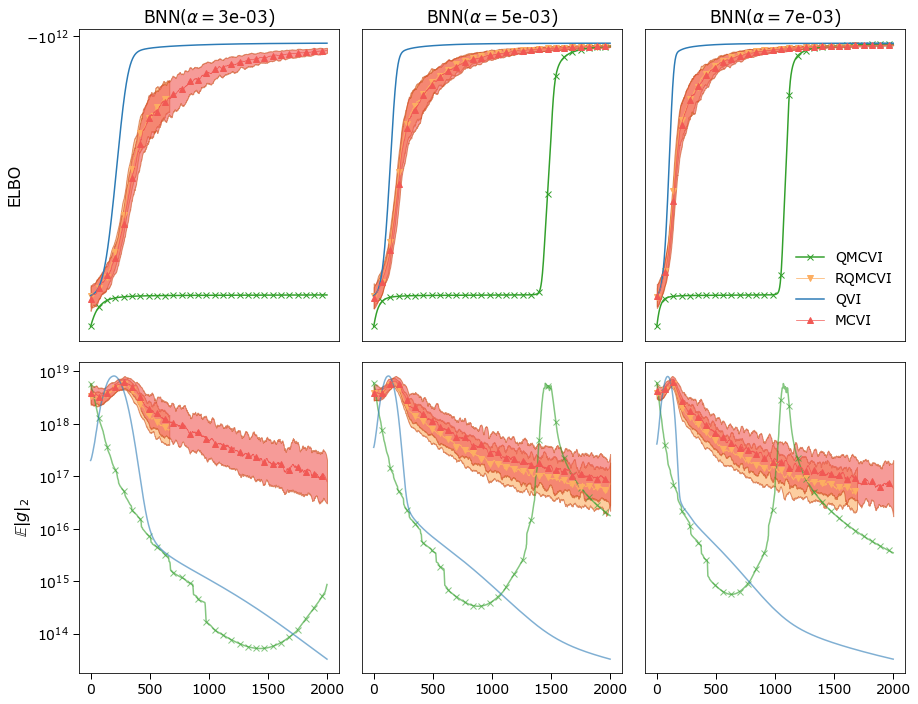

In [54]:
with plt.rc_context(plot_experiments_params):
    fig, axes = plt.subplots(2,len(bnn_results))
    plot_experiments(bnn_results, 
                     axes=axes, 
                     dataset=0,
                     dataset_name='BNN', 
                     vi_type=[ 'mc', 'qvi', 'rqmc', 'qmc', ],
                     norm=1e5)

    axes[0,2].legend(['QMCVI','RQMCVI','QVI','MCVI'])
    axes[1,2].legend([])
    
    plt.tight_layout()